In [27]:
!pip install ws3

  Using cached ws3-0.0.1.post3-py3-none-any.whl (48 kB)
     |████████████████████████████████| 15.4 MB 7.7 MB/s eta 0:00:01
  Using cached profilehooks-1.12.0-py2.py3-none-any.whl (12 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
!pip install pylandstats

     |████████████████████████████████| 51 kB 1.1 kB/s  eta 0:00:01
     |████████████████████████████████| 84 kB 43 kB/s s eta 0:00:01
     |████████████████████████████████| 45 kB 1.7 MB/s  eta 0:00:01
     |████████████████████████████████| 42 kB 831 kB/s  eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import pickle
import pylandstats

In [5]:
gdf = gpd.read_file('dat/shp/tsa00.shp/stands.shp')

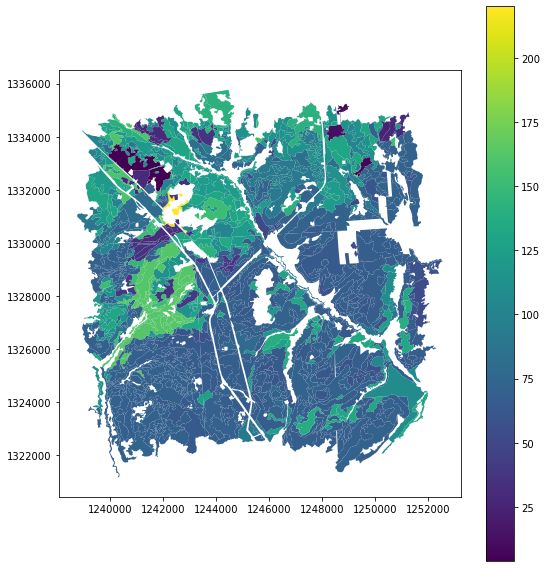

In [873]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot('age', figsize=(10, 10), ax=ax, legend=True)
plt.tight_layout()
fig.savefig('agemap.pdf')

In [7]:
import os
from os import listdir
from os.path import isfile, join, dirname
import sys

In [8]:
ws3_path = os.path.abspath('./ws3')
_path = os.path.abspath(join(dirname(os.path.abspath('')), ws3_path))
if not _path in os.sys.path: os.sys.path.insert(0, _path)
import ws3

In [9]:
ws3

<module 'ws3' from '/media/data/project/gparadis/ws3_spatialoptimize/ws3/ws3/__init__.py'>

In [10]:
def rasterize_inventory(basenames, shp_path, tif_path, hdt_path, theme_cols, age_col, base_year,
                        age_divisor=1., round_age=1., cap_age=None, d=100., verbose=True):
    hdt = {}
    for bn in basenames:
        kwargs = {'shp_path':'%s/stands.shp' % shp_path(bn), 
                  'tif_path':'%s/inventory_init.tif' % tif_path(bn), 
                  'theme_cols':theme_cols, 
                  'age_col':age_col, 
                  'age_divisor':age_divisor,
                  'round_age':round_age,
                  'cap_age':cap_age,
                  'verbose':verbose,
                  'd':d}
        hdt[bn] = ws3.common.rasterize_stands(**kwargs)
        pickle.dump(hdt[bn], open('%s/hdt_%s.pkl' % (hdt_path, bn), 'wb'))
    return hdt


In [211]:
dat_path = 'dat'
basenames = ['tsa00']
shp_path = lambda bn: './dat/shp/tsa00'
tif_path = lambda bn: './dat/tif/tsa00'
hdt_path = lambda bn: './dat/hdt/hdt_tsa00.pkl'
snk_epsg = 3005 # BC Albers
tolerance = 10.
prop_names = [u'THLB', u'AU', u'LdSpp', u'Age2015', u'Shape_Area']
prop_types = [(u'theme0', 'str:10'),
              (u'theme1', 'str:1'),
              (u'theme2', 'str:5'), 
              (u'theme3', 'str:50'), 
              (u'age', 'int:5'), 
              (u'area', 'float:10.1')]
update_area_prop = 'area'
pixel_width = 100.
shp_name = 'stands'
age_col = 'age'
theme_cols = ['theme0', 'theme1', 'theme2', 'theme3']
compress = 'lzw'
dtype = rasterio.uint8
base_year = 2015

tvy_name = 'totvol'
horizon = 100
period_length = 1
max_age = 1000
oe_harvest = '_age >= 40 and _age <= 999'
action_params = {'harvest':{'oe':oe_harvest,
                            'mask':('?', '1', '?', '?'),
                            'is_harvest':True,
                            'targetage':0}}
yields_x_unit = 'years'
yields_period_length = 1

In [212]:
from ws3.common import rasterize_stands
hdt = {}
hdt['tsa00'] = rasterize_stands('./dat/shp/tsa00.shp', './dat/tif/tsa00/inventory_init.tif', theme_cols, age_col, d=pixel_width)

In [213]:
import pickle
pickle.dump(hdt['tsa00'], open('./dat/hdt/hdt_tsa00.pkl', 'wb'))

In [214]:
def compile_basecodes(hdt, basenames, theme_cols):
    import numpy as np
    bc1 = {bn:[list(np.unique(x)) for x in zip(*hdt[bn].values())] for bn in basenames}
    bc2 = [set() for _ in range(len(theme_cols))]
    for bn in basenames:
        for i in range(len(theme_cols)):
            bc2[i].update(bc1[bn][i])
    basecodes = [list(bc2[i]) for i in range(len(theme_cols))]
    return basecodes

In [215]:
basecodes = compile_basecodes(hdt, basenames, theme_cols)

In [216]:
def bootstrap_themes(fm, theme_cols=['theme0', 'theme1', 'theme2', 'theme3'], 
                     basecodes=[[], [], [], []], aggs=[{}, {}, {}, {}], verbose=False):
    for ti, t in enumerate(theme_cols):
        fm.add_theme(t, basecodes=basecodes[ti], aggs=aggs[ti])
    fm.nthemes = len(theme_cols)


def bootstrap_areas(fm, basenames, rst_path, yld_path, hdt, year=None, new_dts=True):
    import shutil
    print('bootstrap_areas', basenames)
    if not year:
        for bn in basenames:
            print('copying', '%s/inventory_init.tif' % rst_path(bn), 
                  '%s/inventory_%i.tif' % (rst_path(bn), fm.base_year))
            shutil.copyfile('%s/inventory_init.tif' % rst_path(bn), 
                            '%s/inventory_%i.tif' % (rst_path(bn), fm.base_year))
        year = fm.base_year
    for dt in fm.dtypes.values(): # yuck
        dt.reset_areas(0)
        dt.reset_areas()
    for bn in basenames:
        _sumarea = 0.
        with rasterio.open('%s/inventory_%i.tif' % (rst_path(bn), year), 'r') as src:
            pxa = pow(src.transform.a, 2) * 0.0001 # pixel area (hectares)
            bh, ba = src.read(1), src.read(2)
            n = 0
            for h, dt in hdt[bn].items():
                ra = ba[np.where(bh == h)] # match themes hash value
                if new_dts:
                    fm.dtypes[dt] = ws3.forest.DevelopmentType(dt, fm)
                for age in np.unique(ra):
                    _age = age
                    area = len(ra[np.where(ra == age)]) * pxa
                    _sumarea += area
                    fm.dtypes[dt].area(0, _age, area)
        print('bootstrap_areas', bn, year, pxa, _sumarea)

        
def bootstrap_yields(fm, yld_path, spcode='canfi_species', 
                        x_max=350, period_length=10., tvy_name='totvol', x_unit='years'):
    import math
    au_table = pd.read_csv('%s/au_table.csv' % yld_path).set_index('au_id')
    curve_table = pd.read_csv('%s/curve_table.csv' % yld_path)
    curve_points_table = pd.read_csv('%s/curve_points_table.csv' % yld_path).set_index('curve_id')
    #print(au_table.shape)

    # add constants (for bird AF coefficients)    
    c1 = fm.constants['birdaf_swvol_coeff'] =     +2.181e-3
    c2 = fm.constants['birdaf_hwvol_coeff'] =     -1.176e-2
    c3 = fm.constants['birdaf_age_coeff'] =       -8.235e-4
    c4 = fm.constants['birdaf_intercept_coeff'] = +7.594e-1

    swvol_ynames = ['s0105', 's0204', 's0101', 's0304', 's0100', 's0104']
    hwvol_ynames = ['s1201', 's1211']

    for au_id, au_row in au_table.iterrows():
        curve_id = au_row.unmanaged_curve_id # if not is_managed else au_row.managed_curve_id
        mask = ('?', '?', str(curve_id), '?')
        dt_keys = fm.unmask(mask)
        if not dt_keys: continue
        
        # add volume curve
        yname = 's%04d' % int(au_row.canfi_species)
        points = [(r.x, r.y) for _, r in curve_points_table.loc[curve_id].iterrows() if not r.x % period_length and r.x <= x_max]
        curve = fm.register_curve(ws3.core.Curve(yname, points=points, type='a', is_volume=True, xmax=fm.max_age, period_length=period_length))
        fm.yields.append((mask, 'a', [(yname, curve)]))
        fm.ynames.add(yname)
        for dtk in dt_keys: 
            fm.dtypes[dtk].add_ycomp('a', yname, curve)
        
        # add birdaf curve
        curve = curve * (c1 if yname in swvol_ynames else c2) + fm.common_curves['ages'] * c3 + c4
        points = [(x, math.exp(y)) for x, y in curve.points()]
        #####################################################################################################################
        # remove negative y values (else negative values will "cancel out" positive values when rolled up to landscape level)
        # TO DO: confirm that this is "the right thing to do" (i.e., consistent with statistical interpretation of bird AF)
        #points = [(x, max(0., y)) for x, y in curve.points()]
        #####################################################################################################################
        curve.add_points(points=points, compile_y=True) 
        yname = 'birdaf'
        fm.yields.append((mask, 'a', [(yname, curve)]))
        fm.ynames.add(yname)
        for dtk in dt_keys: 
            fm.dtypes[dtk].add_ycomp('a', yname, curve)
                
    mask = ('?', '?', '?', '?')
                
    # add total volume curve ###
    expr = '_SUM(%s)' % ', '.join(fm.ynames)
    fm.yields.append((mask, 'c', [(tvy_name, expr)]))
    fm.ynames.add(tvy_name)
    for dtk in fm.dtypes.keys(): fm.dtypes[dtk].add_ycomp('c', tvy_name, expr)  
    
    ## add softwood volume curve
    #yname = 'swvol'
    #expr = '_SUM(%s)' % ', '.join(swvol_ynames)
    #fm.yields.append((mask, 'c', [(yname, expr)]))
    #fm.ynames.add(yname)
    #for dtk in fm.dtypes.keys(): fm.dtypes[dtk].add_ycomp('c', yname, expr)
    
    # add hardwood volume curve
    #yname = 'hwvol'
    #expr = '_SUM(%s)' % ', '.join(hwvol_ynames)
    #fm.yields.append((mask, 'c', [(yname, expr)]))
    #fm.ynames.add(yname)
    #for dtk in fm.dtypes.keys(): fm.dtypes[dtk].add_ycomp('c', yname, expr)  
    
def bootstrap_actions(fm, action_params):
    for acode in action_params:
        ap = action_params[acode]
        mask, oe, is_harvest, targetage = ap['mask'], ap['oe'], ap['is_harvest'], ap['targetage']
        target = [(mask, 1.0, None, None, None, None, None)]
        fm.actions[acode] = ws3.forest.Action(acode, targetage=targetage, is_harvest=is_harvest)
        fm.oper_expr[acode] = {mask:oe}
        fm.transitions[acode] = {mask:{'':target}}
        for dtk in fm.unmask(mask):
            dt = fm.dtypes[dtk]
            dt.oper_expr[acode] = [oe]
            for age in range(1, fm.max_age):
                if not dt.is_operable(acode, 1, age): continue
                fm.dtypes[dtk].transitions[acode, age] = target

    
def bootstrap_forestmodel(basenames, model_name, model_path, base_year, yld_path, tif_path, horizon, 
                          period_length, max_age, basecodes, action_params, hdt,
                          add_null_action=True, tvy_name='totvol', compile_actions=True,
                          yields_x_unit='periods', yields_period_length=None, verbose=0):
    if not yields_period_length: yields_period_length = period_length
    from ws3.forest import ForestModel
    import math
    fm = ForestModel(model_name=model_name, 
                     model_path=model_path,
                     base_year=base_year,
                     horizon=horizon,     
                     period_length=period_length,
                     max_age=max_age)
    bootstrap_themes(fm, basecodes=basecodes)    
    #print('xxx', yld_path)
    bootstrap_areas(fm, basenames, tif_path, yld_path, hdt)
    bootstrap_yields(fm, yld_path, tvy_name=tvy_name, period_length=yields_period_length, x_unit=yields_x_unit)
    bootstrap_actions(fm, action_params)
    if add_null_action: fm.add_null_action()
    fm.compile_actions()
    fm.reset_actions()
    fm.initialize_areas()
    fm.grow()
    return fm

In [217]:
def _gen_scen_base(fm, basenames, name='base', util=0.85, param_funcs=None, target_scalefactors=None, harvest_acode='harvest', fire_acode='fire', 
                   tvy_name='totvol', toffset=0, obj_mode='min_harea', target_path='./input/targets.csv',
                   max_tp=2020, cacut=None, mask=None):
    fm.foo3 = target_scalefactors
    from functools import partial
    acodes = ['null', harvest_acode, fire_acode]  
    vexpr = '%s * %0.2f' % (tvy_name, util)
    if obj_mode == 'max_hvol':
        sense = ws3.opt.SENSE_MAXIMIZE 
        zexpr = vexpr
    elif obj_mode == 'min_harea':
        sense = ws3.opt.SENSE_MINIMIZE 
        zexpr = '1.'
    else:
        raise ValueError('Invalid obj_mode: %s' % obj_mode)
    if not param_funcs:
        target_scalefactors = {bn:1. for bn in basenames} if not target_scalefactors else target_scalefactors
        df_targets = pd.read_csv(target_path).set_index(['tsa', 'year'])
        param_funcs = {}
        param_funcs['cvcut'] = lambda bn, t: float(df_targets.loc[bn, t]['vcut']) * target_scalefactors[bn] if t <= max_tp else float(df_targets.loc[bn, max_tp]['vcut']) * target_scalefactors[bn]
        param_funcs['cabrn'] = lambda bn, t: float(df_targets.loc[bn, t]['abrn']) if t <= max_tp else float(df_targets.loc[bn, max_tp]['abrn'])
        param_funcs['cflw_acut_e'] = lambda bn, t: df_targets.loc[bn, t]['cflw_acut_e'] if t <= max_tp else df_targets.loc[bn, max_tp]['cflw_acut_e']
        param_funcs['cgen_vcut_e'] = lambda bn, t: df_targets.loc[bn, t]['cgen_vcut_e'] if t <= max_tp else df_targets.loc[bn, max_tp]['cgen_vcut_e']
        param_funcs['cgen_acut_e'] = lambda bn, t: df_targets.loc[bn, t]['cgen_vcut_e'] if t <= max_tp else df_targets.loc[bn, max_tp]['cgen_vcut_e']
        param_funcs['cgen_abrn_e'] = lambda bn, t: df_targets.loc[bn, t]['cgen_abrn_e'] if t <= max_tp else df_targets.loc[bn, max_tp]['cgen_abrn_e']
    coeff_funcs = {'z':partial(cmp_c_z, expr=zexpr)}
    coeff_funcs.update({'cacut_%s' % bn:partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=(bn, '?', '?', '?')) 
                        for bn in basenames})
    coeff_funcs.update({'cvcut_%s' % bn:partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=(bn, '?', '?', '?')) 
                        for bn in basenames})
    if fire_acode:
        for i in ['0', '1']:
            coeff_funcs.update({'cabrn-thlb%s_%s' % (i, bn):partial(cmp_c_caa, expr='1.', acodes=[fire_acode], mask=(bn, i, '?', '?')) 
                                for bn in basenames})
    T = fm.periods# [fm.base_year+(t-1)*fm.period_length for t in fm.periods]
    cflw_e, cgen_data = {}, {}
    #foo = {bn:{t:(bn, t+toffset) for t in T} for bn in basenames}
    #print(T)
    #assert False
    cflw_ebn = {bn:({t:param_funcs['cflw_acut_e'](bn, fm.base_year+(t-1)*fm.period_length+toffset) for t in T}, fm.periods[-1]) for bn in basenames}
    cflw_e.update({'cacut_%s'%bn:cflw_ebn[bn] for bn in basenames})
    for bn in basenames:
        #print(df_targets.loc[bn])
        cgen_data.update({'cvcut_%s' % bn:{'lb':{t:param_funcs['cvcut'](bn, fm.base_year+(t-1)*fm.period_length+toffset) * fm.period_length *
                                                 (1. - param_funcs['cgen_vcut_e'](bn, fm.base_year+(t-1)*fm.period_length+toffset))
                                               for t in T}, 
                                         'ub':{t:param_funcs['cvcut'](bn, fm.base_year+(t-1)*fm.period_length+toffset) * fm.period_length for t in T}}})
        if cacut:
            cgen_data.update({'cacut_%s' % bn:{'lb':{t:param_funcs['cacut'](bn, fm.base_year+(t-1)*fm.period_length) * fm.period_length *
                                                     (1. - param_funcs['cgen_acut_e'](bn, fm.base_year+(t-1)*fm.period_length)) for t in T}, 
                                               'ub':{t:param_funcs['cacut'](bn, fm.base_year+(t-1)*fm.period_length) * fm.period_length for t in T}}})
        if fire_acode:
            for i in ['0', '1']:
                p = fm.inventory(0, mask='? %s ? ?' % i) / fm.inventory(0, mask='? ? ? ?')
                cgen_data.update({'cabrn-thlb%s_%s' % (i, bn):{'lb':{t:param_funcs['cabrn'](bn, fm.base_year+(t-1)*fm.period_length) * p * fm.period_length *
                                                                     (1. - param_funcs['cgen_abrn_e'](bn, fm.base_year+(t-1)*fm.period_length)) for t in T}, 
                                                               'ub':{t:param_funcs['cabrn'](bn, fm.base_year+(t-1)*fm.period_length) * p * fm.period_length for t in T}}})
                #fm.cgen_data = cgen_data
                #assert False
    #print(cflw_e)
    fm._tmp = {}
    fm._tmp['param_funcs'] = param_funcs
    fm._tmp['cgen_data'] = cgen_data
    return fm.add_problem(name, coeff_funcs, cflw_e, cgen_data=cgen_data, acodes=acodes, sense=sense, mask=mask)

In [218]:
def schedule_harvest_areacontrol(fm, period=1, acode='harvest', util=0.85, 
                                 target_masks=None, target_areas=None, target_scalefactors=None,
                                 mask_area_thresh=0.,
                                 verbose=0):
    #fm.reset_actions()
    if not target_areas:
        if not target_masks: # default to AU-wise THLB 
            au_vals = []
            au_agg = []
            for au in fm.theme_basecodes(2):
                mask = '? 1 %s ?' % au
                masked_area = fm.inventory(0, mask=mask)
                if masked_area > mask_area_thresh:
                    au_vals.append(au)
                else:
                    au_agg.append(au)
                    if verbose > 0:
                        print('adding to au_agg', mask, masked_area)
            if au_agg:
                fm._themes[2]['areacontrol_au_agg'] = au_agg 
                au_vals.append('areacontrol_au_agg')
            target_masks = ['? 1 %s ?' % au for au in au_vals]
        #print(target_masks)
        #assert False
        target_areas = []
        for i, mask in enumerate(target_masks): # compute area-weighted mean CMAI age for each masked DT set
            masked_area = fm.inventory(0, mask=mask, verbose=verbose)
            if not masked_area: continue
            r = sum((fm.dtypes[dtk].ycomp('totvol').mai().ytp().lookup(0) * fm.dtypes[dtk].area(0)) for dtk in fm.unmask(mask))
            r /= masked_area
            #awr = []
            #dtype_keys = fm.unmask(mask)
            #for dtk in dtype_keys:
            #    dt = fm.dtypes[dtk]
            #    awr.append(dt.ycomp('totvol').mai().ytp().lookup(0) * dt.area(0))
            #r = sum(awr)  / masked_area
            asf = 1. if not target_scalefactors else target_scalefactors[i]  
            ta = (1/r) * masked_area * asf
            target_areas.append(ta)
    for mask, target_area in zip(target_masks, target_areas):
        if verbose > 0:
            print('calling areaselector', period, acode, target_area, mask)
        fm.areaselector.operate(period, acode, target_area, mask=mask, verbose=verbose)
    sch = fm.compile_schedule()
    return sch

In [219]:
kwargs = {'basenames':basenames,
          'model_name':'foo',
          'model_path':dat_path,
          'base_year':int(base_year),
          'yld_path':dat_path,
          'tif_path':tif_path,
          'horizon':int(horizon),
          'period_length':int(period_length),
          'max_age':int(max_age),
          'basecodes':basecodes,
          'action_params':action_params,
          'hdt':hdt,
          'add_null_action':True,
          'tvy_name':tvy_name,
          'compile_actions':True,
          'yields_x_unit':yields_x_unit,
          'yields_period_length':int(yields_period_length),
          'verbose':1}

In [488]:
fm = bootstrap_forestmodel(**kwargs)

bootstrap_areas ['tsa00']
copying ./dat/tif/tsa00/inventory_init.tif ./dat/tif/tsa00/inventory_2015.tif
bootstrap_areas tsa00 2015 1.0 13031.0


In [489]:
target_masks = ['? ? ? ?']
target_areas = [100.]

In [490]:
#for p in fm.periods:
#    schedule_harvest_areacontrol(fm, period=p, verbose=True)
#sch = schedule_harvest_areacontrol(fm, period=2, verbose=True)
for period in fm.periods:
    schedule_harvest_areacontrol(fm, period=period, target_masks=target_masks, target_areas=target_areas, verbose=True)

calling areaselector 1 harvest 100.0 ? ? ? ?
 entering selector.operate() 15 operable dtypes
 selector found area ['tsa40 1 4001003 105'] harvest 1 220 11.0
 selector found area ['tsa40 1 4001000 101'] harvest 1 162 11.0
 selector found area ['tsa40 1 4002005 100'] harvest 1 162 5.0
 selector found area ['tsa40 1 4001002 204'] harvest 1 162 73.0
GreedyAreaSelector.operate done (remaining target_area: 0.0)
calling areaselector 2 harvest 100.0 ? ? ? ?
 entering selector.operate() 15 operable dtypes
 selector found area ['tsa40 1 4001002 204'] harvest 2 163 21.0
 selector found area ['tsa40 1 4001005 100'] harvest 2 163 20.0
 selector found area ['tsa40 1 4003000 101'] harvest 2 163 48.0
 selector found area ['tsa40 1 4002002 204'] harvest 2 163 11.0
GreedyAreaSelector.operate done (remaining target_area: 0.0)
calling areaselector 3 harvest 100.0 ? ? ? ?
 entering selector.operate() 15 operable dtypes
 selector found area ['tsa40 1 4001003 105'] harvest 3 174 1.0
 selector found area ['ts

In [491]:
{p:fm.compile_product(p, '1.') for p in fm.periods}

{1: 100.0,
 2: 100.0,
 3: 100.0,
 4: 100.0,
 5: 100.0,
 6: 100.0,
 7: 100.0,
 8: 100.0,
 9: 100.0,
 10: 100.0,
 11: 100.0,
 12: 100.0,
 13: 100.0,
 14: 100.0,
 15: 100.0,
 16: 100.0,
 17: 100.0,
 18: 100.0,
 19: 100.0,
 20: 100.0,
 21: 100.0,
 22: 100.0,
 23: 100.0,
 24: 100.0,
 25: 100.0,
 26: 100.0,
 27: 100.0,
 28: 100.0,
 29: 100.0,
 30: 100.0,
 31: 100.0,
 32: 100.0,
 33: 100.0,
 34: 100.0,
 35: 100.0,
 36: 100.0,
 37: 100.0,
 38: 100.0,
 39: 100.0,
 40: 100.0,
 41: 100.0,
 42: 100.0,
 43: 100.0,
 44: 100.0,
 45: 100.0,
 46: 100.0,
 47: 100.0,
 48: 100.0,
 49: 100.0,
 50: 100.0,
 51: 100.0,
 52: 100.0,
 53: 100.0,
 54: 100.0,
 55: 100.0,
 56: 100.0,
 57: 100.0,
 58: 100.0,
 59: 100.0,
 60: 100.0,
 61: 100.0,
 62: 100.0,
 63: 100.0,
 64: 100.0,
 65: 100.0,
 66: 100.0,
 67: 100.0,
 68: 100.0,
 69: 100.0,
 70: 100.0,
 71: 100.0,
 72: 100.0,
 73: 100.0,
 74: 100.0,
 75: 100.0,
 76: 100.0,
 77: 100.0,
 78: 100.0,
 79: 100.0,
 80: 100.0,
 81: 100.0,
 82: 100.0,
 83: 100.0,
 84: 100.0,
 

In [802]:
def sda(fm, basenames, time_step, tif_path, hdt, acode_map=None, nthresh=0, sda_mode='randpxl', verbose=False, aggregate_disturbance=False):
    from pathlib import Path
    from ws3.spatial import ForestRaster
    from ws3.common import hash_dt
    import os
    if acode_map is None:
        acode_map = {'harvest':'projected_harvest'}
    def cmp_fr_kwargs(bn):
        tmp_path = os.path.split(tif_path(bn))[0]
        _tif_path = '%s/%s' % (tmp_path, bn)
        if not Path(_tif_path).exists():
            Path(_tif_path).mkdir()
        fr_kwargs = {'hdt_map':hdt[bn], 
                     'hdt_func':hash_dt, 
                     'src_path':'%s/inventory_%i.tif' % (tif_path(bn), fm.base_year),
                     'snk_path':_tif_path,
                     'acode_map':acode_map,
                     'forestmodel':fm,
                     'horizon':fm.horizon,
                     'period_length':fm.period_length,
                     'time_step':time_step,
                     'base_year':fm.base_year,
                     'piggyback_acodes':{},
                     'disturb_thresh':50}
        return fr_kwargs
    for bn in basenames:
        print('SDA for TSA', bn)
        #mask = (bn, '?', '?', '?')
        mask = None
        fr = ForestRaster(**cmp_fr_kwargs(bn))
        fr.allocate_schedule(mask=mask, verbose=verbose, sda_mode=sda_mode, aggregate_disturbance=aggregate_disturbance)
        fr.cleanup()

In [840]:
acode_map = {acode:'projected_%s' % acode for acode in fm.actions.keys() if acode not in ['null']}

In [841]:
sda(fm, basenames, 1, tif_path, hdt, acode_map, sda_mode='randblk', aggregate_disturbance=True, verbose=3)

SDA for TSA tsa00
processing schedule for period 1
processing case 1 harvest ('tsa40', '1', '4001003', '105') 220 11.0
dy 0
0 0.0 inf 11.0
missing area: harvest 0 11.0 ['tsa40', '1', '4001003', '105']
n 0 tarea 11.0
processing case 1 harvest ('tsa40', '1', '4001000', '101') 162 11.0
dy 0
0 0.0 inf 11.0
missing area: harvest 0 11.0 ['tsa40', '1', '4001000', '101']
n 0 tarea 11.0
processing case 1 harvest ('tsa40', '1', '4002005', '100') 162 5.0
dy 0
0 0.0 inf 5.0
missing area: harvest 0 5.0 ['tsa40', '1', '4002005', '100']
n 0 tarea 5.0
processing case 1 harvest ('tsa40', '1', '4001002', '204') 162 73.0
dy 0
0 0.0 inf 73.0
missing area: harvest 0 73.0 ['tsa40', '1', '4001002', '204']
n 0 tarea 73.0
saving 2015 post-harvest pixels to ./dat/tif/tsa00/inventory_2015.tif
processing schedule for period 2
processing case 2 harvest ('tsa40', '1', '4001002', '204') 163 21.0
dy 0
0 0.0 inf 21.0
missing area: harvest 0 21.0 ['tsa40', '1', '4001002', '204']
n 0 tarea 21.0
processing case 2 harvest

In [843]:
dates = list(range(2015, 2015+fm.horizon))

In [844]:
[np.sum(rasterio.open('dat/tif/tsa00/projected_harvest_%i.tif' % year).read(1)) for year in dates]

[0,
 79,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 95,
 100,
 96,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 67,
 100,
 100,
 87,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 99,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 58,
 100,
 100,
 100,
 90,
 100,
 7,
 94,
 100,
 100,
 100,
 94,
 100,
 100,
 44,
 11,
 75,
 56,
 0,
 61,
 7,
 2,
 53,
 22,
 0,
 0,
 5,
 0,
 0,
 8]

In [845]:
import pylandstats as pls

In [846]:
landscapes = [(rasterio.open('./dat/tif/tsa00/inventory_%i.tif' % year).read(2) * 0.1).astype(int) for year in dates]

In [860]:
sta = pls.SpatioTemporalAnalysis(landscapes, dates, res=(100, 100))

In [861]:
metrics = ['landscape_shape_index', 'number_of_patches']

In [862]:
df = sta.compute_landscape_metrics_df(metrics=metrics)

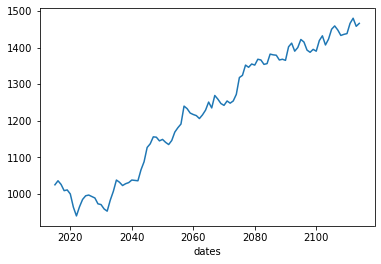

In [863]:
df.number_of_patches.plot()

In [851]:
df_agg100 = df

In [852]:
import matplotlib.pyplot as plt

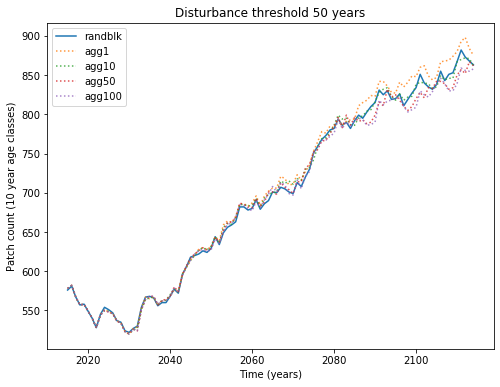

In [853]:
fig, ax = plt.subplots(figsize=(8, 6))
alpha = 0.8

df_randblk.number_of_patches.plot(ax=ax, label='randblk')
df_agg1.number_of_patches.plot(ax=ax, label='agg1', alpha=alpha, linestyle=':')
#df_agg5.number_of_patches.plot(ax=ax, label='agg5')
df_agg10.number_of_patches.plot(ax=ax, label='agg10', alpha=alpha, linestyle=':')
df_agg50.number_of_patches.plot(ax=ax, label='agg50', alpha=alpha, linestyle=':')
df_agg100.number_of_patches.plot(ax=ax, label='agg100', alpha=alpha, linestyle=':')
#df_agg1000.number_of_patches.plot(ax=ax, label='agg1000')
plt.ylabel('Patch count (10 year age classes)')
plt.xlabel('Time (years)')
plt.title('Disturbance threshold 50 years')
plt.legend()
plt.savefig('dt50.pdf')

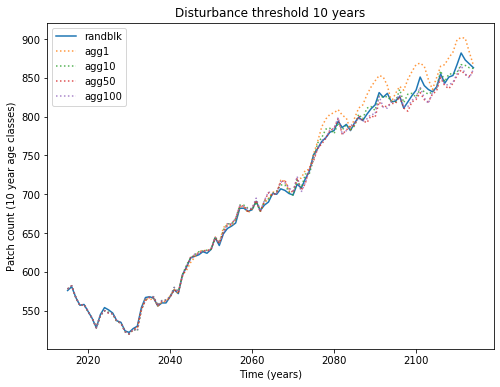

In [777]:
fig, ax = plt.subplots(figsize=(8, 6))
alpha = 0.8

df_randblk.number_of_patches.plot(ax=ax, label='randblk')
df_agg1.number_of_patches.plot(ax=ax, label='agg1', alpha=alpha, linestyle=':')
#df_agg5.number_of_patches.plot(ax=ax, label='agg5')
df_agg10.number_of_patches.plot(ax=ax, label='agg10', alpha=alpha, linestyle=':')
df_agg50.number_of_patches.plot(ax=ax, label='agg50', alpha=alpha, linestyle=':')
df_agg100.number_of_patches.plot(ax=ax, label='agg100', alpha=alpha, linestyle=':')
#df_agg1000.number_of_patches.plot(ax=ax, label='agg1000')
plt.ylabel('Patch count (10 year age classes)')
plt.xlabel('Time (years)')
plt.title('Disturbance threshold 10 years')
plt.legend()
plt.savefig('dt10.pdf')

In [385]:
df_randblk = df

In [287]:
sta.compute_class_metrics_df(metrics=metrics, classes=[1])

metric           landscape_shape_index  number_of_patches
class_val dates                                          
1         2015                2.166667                3.0
          2016                2.166667                3.0
          2017                2.166667                3.0
          2018                2.666667                4.0
          2019                2.666667                4.0
...                                ...                ...
          2110               10.052632               39.0
          2111                9.964286               39.0
          2112                9.807692               38.0
          2113                9.647059               37.0
          2114                8.574468               30.0

[100 rows x 2 columns]

In [516]:
import scipy
from matplotlib import pyplot

In [531]:
#disturb_heat = scipy.ndimage.gaussian_filter((self._x[1] <= self._disturb_thresh).astype(int), sigma=10)
disturb_thresh = 10
src = rasterio.open('./dat/tif/tsa00/inventory_2015.tif')
x = src.read()
disturb_heat = scipy.ndimage.gaussian_filter((x[1] <= disturb_thresh).astype(float), sigma=10)

In [529]:
np.unique((x[1] <= disturb_thresh).astype(int))

array([0, 1])

In [530]:
np.sum((x[1] <= disturb_thresh).astype(int))

7269

In [532]:
np.unique(disturb_heat)

array([0.04713872, 0.04725947, 0.04728112, ..., 0.96606352, 0.96627499,
       0.96711012])

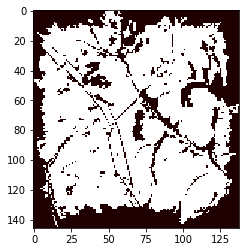

In [867]:
pyplot.imshow(src.read(2), cmap='pink')

In [524]:
np.unique(x[0])

array([-2147483648, -1999088744, -1915452737, -1874541126, -1820345152,
       -1681453637, -1435573515, -1292284510, -1083339805,  -944784477,
        -923813008,  -868800184,  -460292654,  -387276266,  -254578803,
        -215981537,    85913522,   100970121,   107606225,   481257381,
         951550072,   966688282,  1064353446,  1111059247,  1298532196,
        1350131557,  1549192256,  1579217071,  1916352226,  2002498417,
        2096855225], dtype=int32)

In [528]:
np.unique(x[1])

array([-2147483648,           4,           7,          12,          25,
                28,          29,          30,          31,          32,
                33,          34,          36,          37,          39,
                40,          41,          47,          52,          53,
                54,          58,          60,          62,          63,
                64,          65,          66,          67,          68,
                69,          70,          71,          72,          73,
                74,          75,          78,          80,          82,
                84,          88,          90,          91,          92,
                94,          95,          98,         100,         102,
               103,         107,         108,         109,         110,
               112,         114,         118,         120,         122,
               128,         129,         130,         132,         133,
               134,         135,         137,         138,      

In [505]:
np.sum(disturb_heat)

0

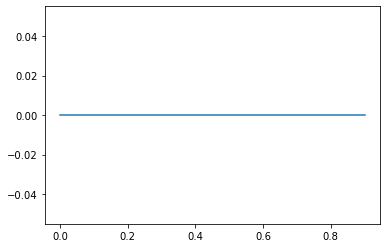

In [508]:
histogram, bin_edges = np.histogram(x[1], bins=10, range=(0, 1))

plt.plot(bin_edges[0:-1], histogram)

In [507]:
np.hist(x[1])

AttributeError: module 'numpy' has no attribute 'hist'

In [503]:
x[1] <= disturb_thresh

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [509]:
foo = (rasterio.open('./dat/tif/tsa00/inventory_%i.tif' % 2015).read(2) * 0.1).astype(int)

In [510]:
ls = pls.Landscape(foo, res=(100, 100))

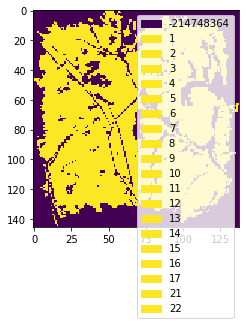

In [511]:
ls.plot_landscape(legend=True)

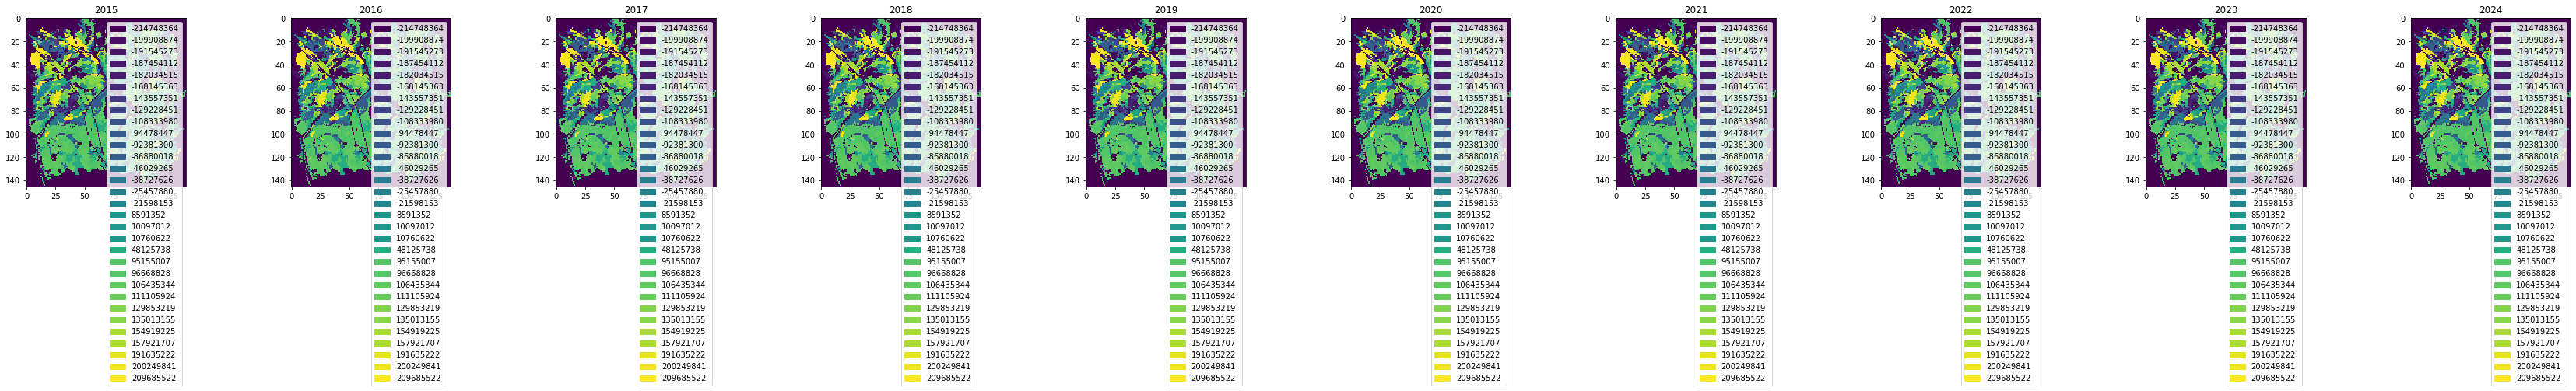

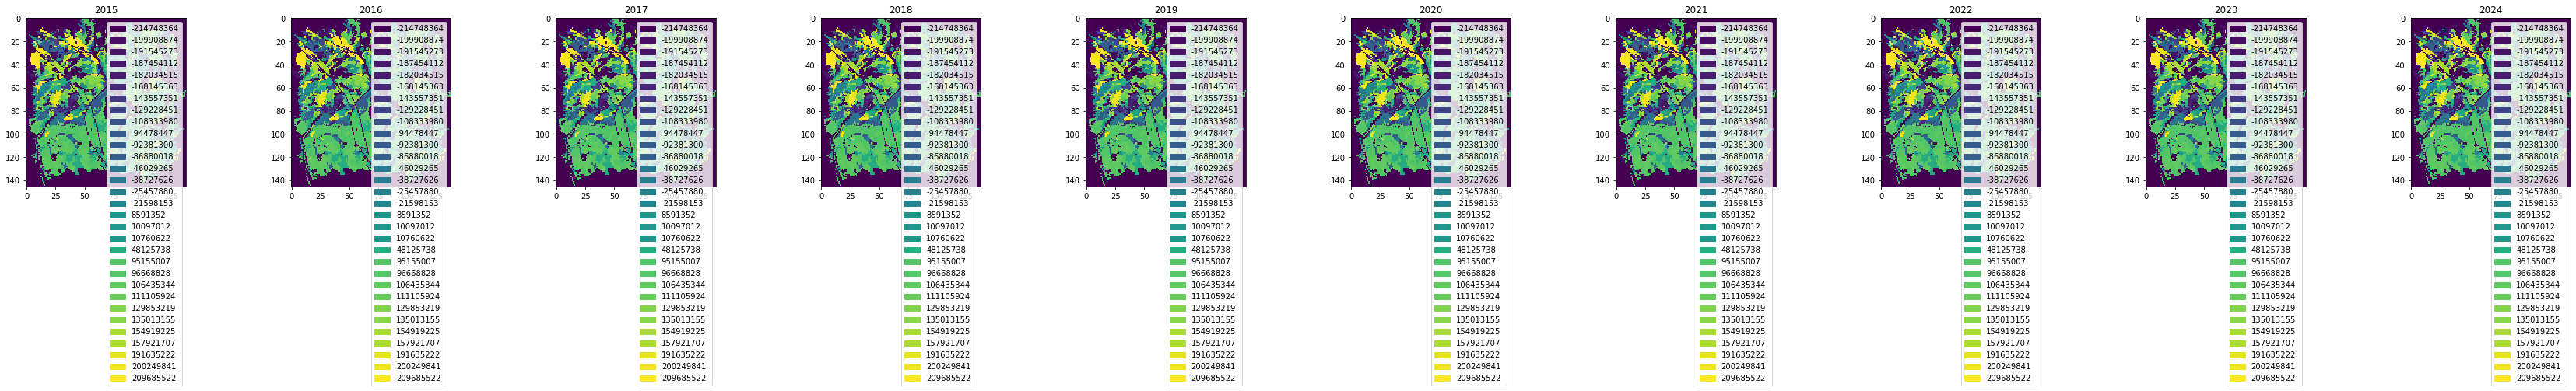

In [110]:
sta.plot_landscapes()

In [67]:
class_metrics_df = ls.compute_class_metrics_df(metrics=['landscape_shape_index', 'number_of_patches'])

In [68]:
class_metrics_df

,landscape_shape_index,number_of_patches
class_val,,
-214748364,14.757396,145
1,2.166667,3
2,3.000000,3
3,5.171429,14
4,3.000000,5
5,6.540541,21
6,12.792593,48
7,11.235294,39
8,7.150000,26


In [23]:
a = ws3.spatial._ForestRaster___foo

AttributeError: module 'ws3' has no attribute 'spatial'

In [24]:
#a = rasterio.open('./dat/tif/tsa00/inventory_init.tif').read()

In [25]:
np.where(a[0] == 1064353446)[0].sum()

NameError: name 'a' is not defined

In [26]:
np.where(a[1] == 138)[0].sum()

NameError: name 'a' is not defined

In [27]:
np.where((a[0] == 1064353446) & (a[1] == 138))[0].sum()

NameError: name 'a' is not defined

In [131]:
img = rasterio.open('dat/tif/tsa00/projected_harvest_2015.tif')

In [133]:
a = img.read(1)

In [134]:
np.sum(a)

2041

In [32]:
!cp dat/tif/tsa00/projected_harvest_2015.tif .

In [311]:
from skimage import io
from sklearn.feature_extraction import image
from sklearn.datasets import load_sample_image
img = load_sample_image('flower.jpg')
img.shape



(427, 640, 3)

In [313]:
patches = image.extract_patches_2d(img, (2, 2))
print('Patches shape: {}'.format(patches.shape))


Patches shape: (272214, 2, 2, 3)


In [300]:
!pip install scikit-learn

     |████████████████████████████████| 26.7 MB 10.9 MB/s eta 0:00:01
     |████████████████████████████████| 306 kB 77.8 MB/s eta 0:00:01


In [304]:
!pip install scikit-image

     |████████████████████████████████| 14.0 MB 11.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 70.4 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 68.0 MB/s eta 0:00:01
     |████████████████████████████████| 179 kB 80.0 MB/s eta 0:00:01
ERROR: imageio 2.16.1 has requirement pillow>=8.3.2, but you'll have pillow 7.0.0 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
